# Debug detsim city NB

### JAH 12/12/19

In [1]:
import time

%load_ext autoreload
%autoreload 2

import numpy             as np
import scipy             as sc
import scipy.stats       as st
import tables            as tb

from typing    import Callable
from typing    import Tuple
from typing    import List

import invisible_cities.io.mcinfo_io               as mcio
import invisible_cities.core    .system_of_units_c as system_of_units
import invisible_cities.core    .fit_functions     as fitf
import invisible_cities.database.load_db           as db

from   invisible_cities.reco.corrections_new import read_maps

import myhistos                            as ht
import detsim.simulation.detsim_functions  as ds
import detsim.simulation.detsim_plots      as dsplot



units = system_of_units.SystemOfUnits()

# Plotting configuration

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
np.warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"]          = 5, 4
plt.rcParams["font.size"]               = 12
plt.rcParams["figure.max_open_warning"] = 100

## DetSim

In [3]:
detector, run_number = 'new', -1
krmap_filename   = '/Users/hernando/investigacion/NEXT/work/detsim/detsim/test_data/MC_NEW_Kr_map.h5'
psfsipm_filename = '/Users/hernando/investigacion/NEXT/work/detsim/detsim/test_data/PSF_SiPM_dst_sum_collapsed.h5'
dsim             = ds.DetSimParameters(detector, run_number, krmap_filename, psfsipm_filename)

load psf pmt  from file :  /Users/hernando/investigacion/NEXT/work/detsim/detsim/test_data/MC_NEW_Kr_map.h5
load psf sipm from file :  /Users/hernando/investigacion/NEXT/work/detsim/detsim/test_data/PSF_SiPM_dst_sum_collapsed.h5


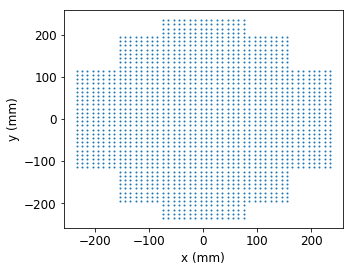

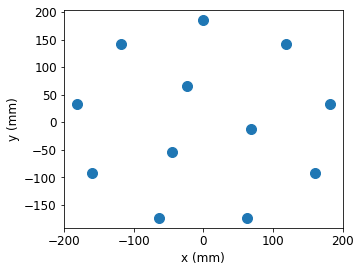

In [4]:
plt.scatter(dsim.x_sipms, dsim.y_sipms, s = 1.)
plt.xlabel('x (mm)'); plt.ylabel('y (mm)');
plt.figure()
plt.scatter(dsim.x_pmts, dsim.y_pmts, s = 1e2)
plt.xlabel('x (mm)'); plt.ylabel('y (mm)');

In [5]:
generate_wfs_       = ds.get_function_generate_wfs(detector, run_number, krmap_filename, psfsipm_filename)
simulate_electrons_ = ds.get_function_simulate_electrons(dsim)
simulate_pes_       = ds.get_function_simulate_pes(dsim)
simulate_wfs_       = ds.get_function_simulate_wfs(dsim)

load psf pmt  from file :  /Users/hernando/investigacion/NEXT/work/detsim/detsim/test_data/MC_NEW_Kr_map.h5
load psf sipm from file :  /Users/hernando/investigacion/NEXT/work/detsim/detsim/test_data/PSF_SiPM_dst_sum_collapsed.h5


## Data

In [6]:
datadir      = '/Users/hernando/investigacion/NEXT/work/detsim/detsim/test_data/'
datafilename = 'neut_full_test.sim.h5'

In [7]:
def hits_generator():
    datahits = mcio.load_mchits_df(datadir + datafilename)
    hitsgroup = datahits.groupby('event_id')
    print('size ', len(hitsgroup))
    for ievt, hitsdf in hitsgroup:
        print('event ', ievt)
        yield(ievt, hitsdf)

In [8]:
it = hits_generator()

## Run -Steps

In [9]:
evt, hits = next(it)

size  3
event  0


total energy  336.645245552063  keV
number of diffused electrons  14613
longitudinal diffusion  1.2306540613431896
transverse diffusion 4.102180204477299


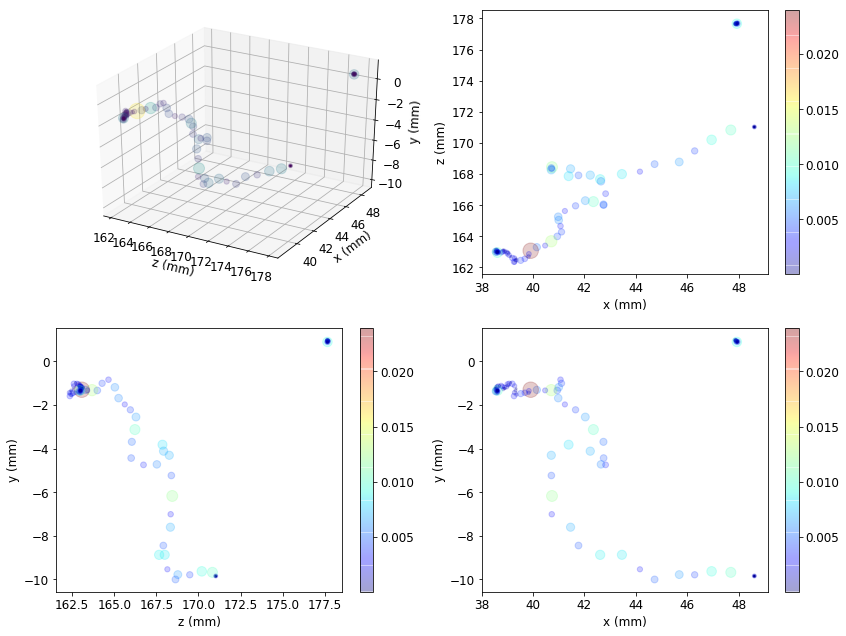

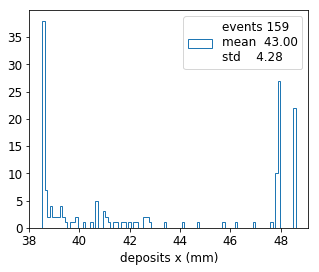

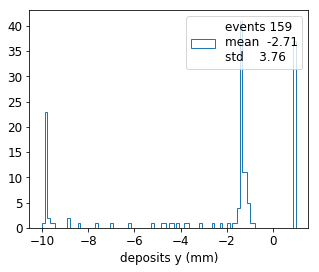

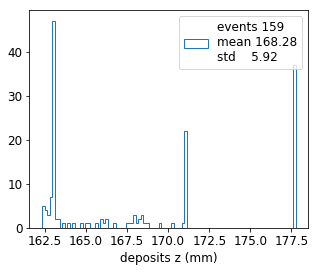

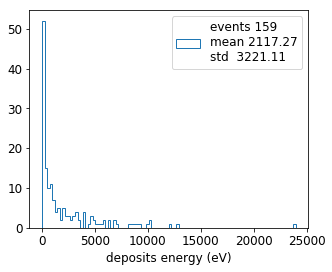

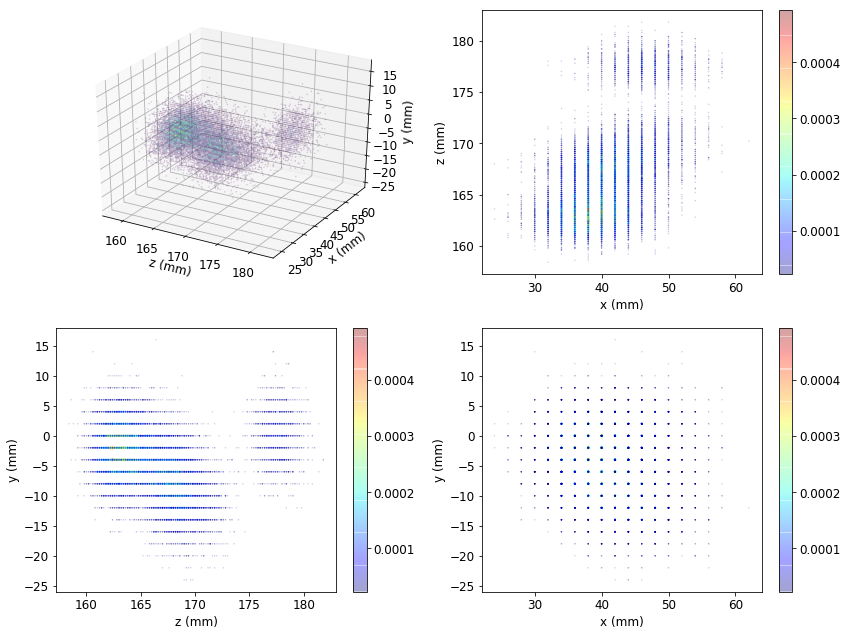

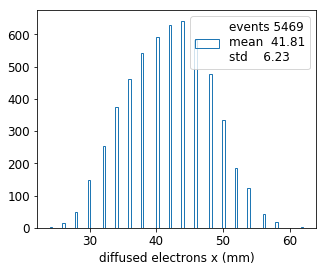

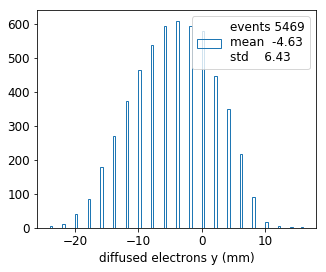

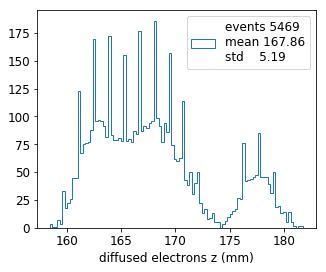

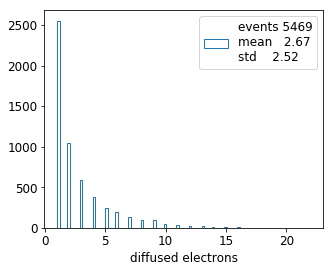

In [10]:
posenes, posdnes = simulate_electrons_(hits)
dsplot.plot_simulate_electrons(dsim, posenes, posdnes)

number of S1 photons 5600
number of S2 photons 14610965.367363436
total pes_s1 46
pes_S1  [5 7 5 4 4 2 2 3 4 4 3 3]
total pes_pmts 103681
pes_pmts  [8643 8684 8622 8724 8608 8654 8655 8600 8691 8785 8526 8489]
pes_sipms  [0 0 0 ... 0 0 0]
total pes_sipms 9368


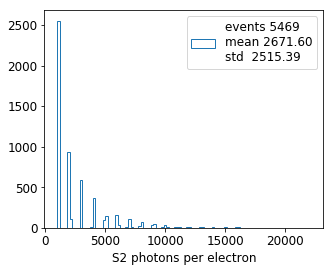

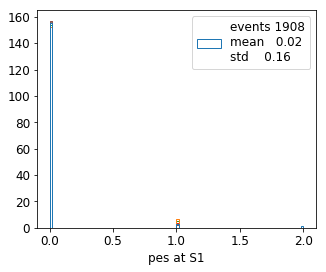

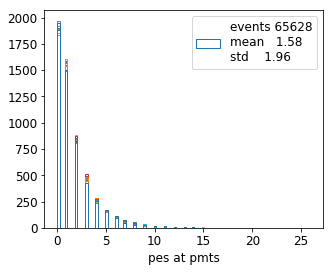

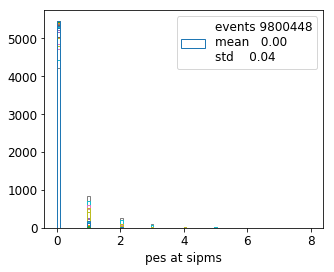

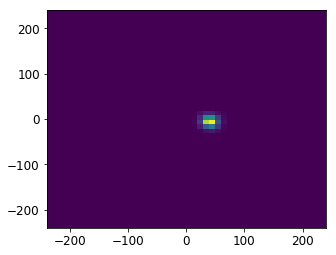

In [11]:
s1pes, s2pes = simulate_pes_(posenes, posdnes)
dsplot.plot_simulate_pes(dsim, s1pes, s2pes)

total adcs pmts  2580272.3125
total adcs sipms 152422.6895


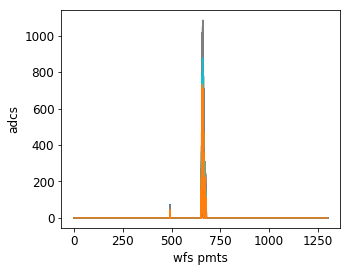

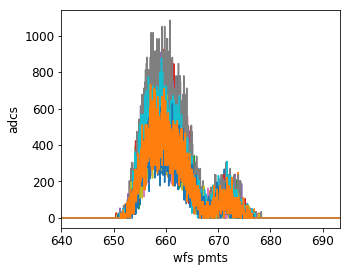

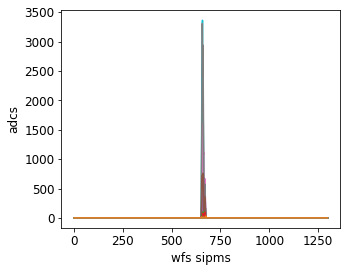

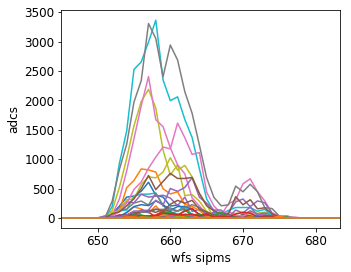

In [12]:
wfs_pmts, wfs_sipms = simulate_wfs_(s1pes, s2pes)
s2photons, dts, pes_pmts, pes_sipms = s2pes
dsplot.plot_simulate_wfs(dsim, wfs_pmts, wfs_sipms, dts)

## Timings

In [13]:
def time_to_simulate_one_event(hits, n = 1):
    t0 = time.time()
    for i in range(n):
        generate_wfs_(hits)
    return (time.time() - t0) / n

In [14]:
dtsim = time_to_simulate_one_event(hits, n = 10)
print('total ', dtsim, 's')

total  1.3295741081237793 s


event  1
total energy 223.58062863349915  keV
total  1.039438796043396 s


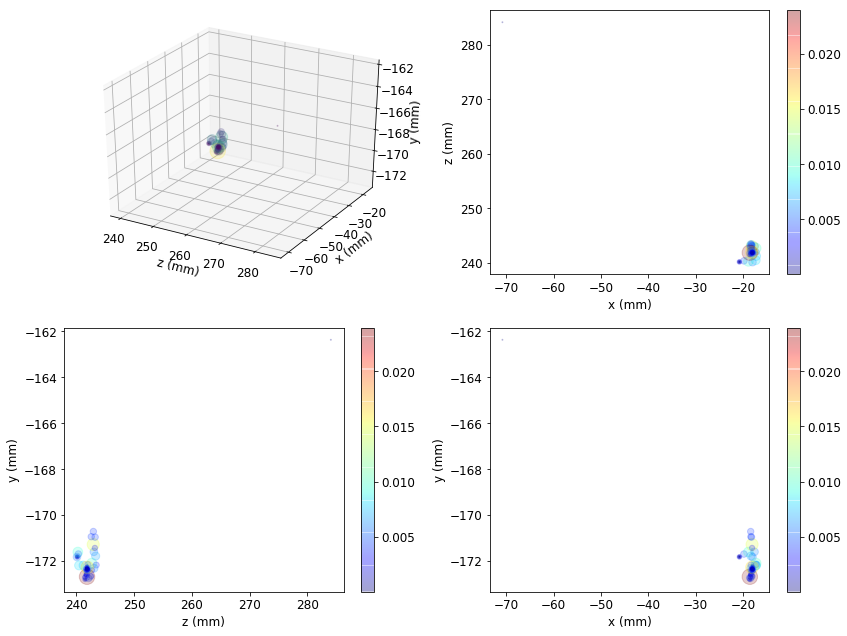

In [15]:
evt, hits = next(it)
xs, ys, zs, enes = ds.get_deposits(hits)
print('total energy', np.sum(enes) / units.keV, ' keV');
ht.graph_event(xs, ys, zs, enes, scale = 1e4)
dtsim = time_to_simulate_one_event(hits, n = 10)
print('total ', dtsim, 's')

event  2
total energy 126.0291337966919  keV
total  0.6244343042373657 s


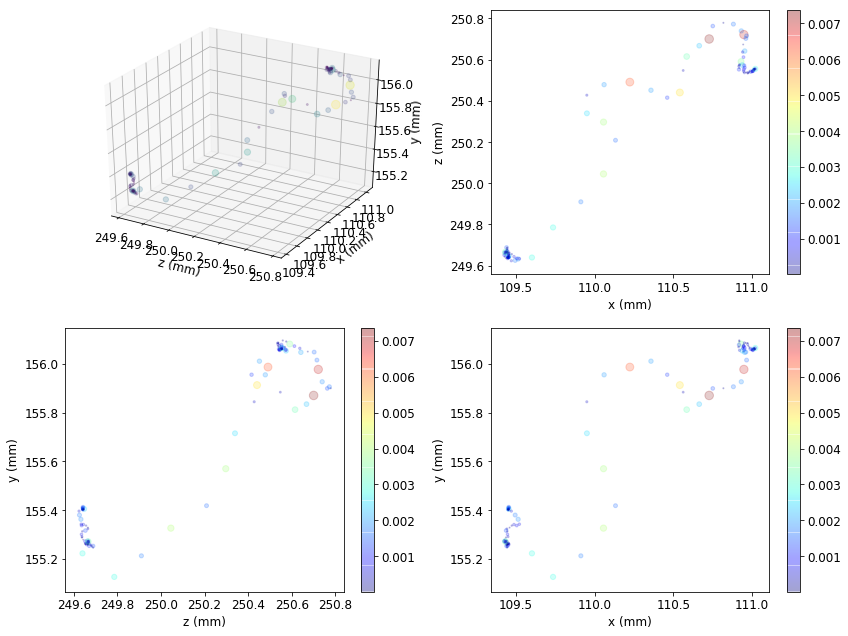

In [16]:
evt, hits = next(it)
xs, ys, zs, enes = ds.get_deposits(hits)
print('total energy', np.sum(enes) / units.keV, ' keV');
ht.graph_event(xs, ys, zs, enes, scale = 1e4)
dtsim = time_to_simulate_one_event(hits, n = 10)
print('total ', dtsim, 's')